# Spiker 

In [1]:
# Set the path
import sys
sys.path.append("/home/ubuntu/ACT")

from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.act_types import SimulationParameters, ConstantCurrentInjection, FilterParameters, ConductanceOptions, OptimizationParameters
from act.data_processing import *
from act.act_module import ACTModule, ACTModuleParameters

import numpy as np
import matplotlib.pyplot as plt

--No graphics will be displayed.


1. Generate target traces to tune to (as if they were provided by the user).

In [2]:
# Define the "target" cell
target_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "/home/ubuntu/ACT/data/Spiker/orig/template.hoc",
    path_to_mod_files = "/home/ubuntu/ACT/data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [3]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

for sim_idx, amp_value in enumerate([0.1, 0.5, 1.0]):
    sim_params = SimulationParameters(
        sim_name = "spiker_orig/target",
        sim_idx = sim_idx,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 700, delay = 100, lto_hto = 0)])

    simulator.submit_job(target_cell, sim_params)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [4]:
simulator.run_jobs(3)

In [5]:
# Combine simulated traces into one dataset for convenience
combine_data("output/spiker_orig/target")

output/spiker_orig/target


In [6]:
# Plot the traces and the FI curve
simulated_data = np.load("output/spiker_orig/target/combined_out.npy") # 3 x 10000 x 4; (n_sim x time x [V, I, g, lto_hto])

Text(0, 0.5, 'Voltage (mV)')

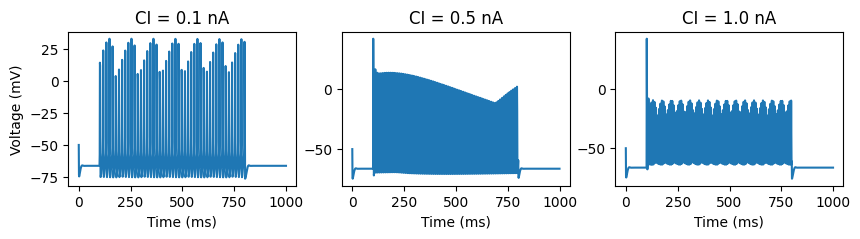

In [7]:
fig, ax = plt.subplots(1, 3, figsize = (10, 2))
for axid, amp in enumerate([0.1, 0.5, 1.0]):
    ax[axid].plot(simulated_data[axid, ::10, 0])
    ax[axid].set_xlabel("Time (ms)")
    ax[axid].set_title(f"CI = {amp} nA")

ax[0].set_ylabel("Voltage (mV)")

In [8]:
frequencies = get_fi_curve(
    simulated_data[:, ::10, 0],
    -30,
    [ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100, lto_hto = 0),
     ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0),
     ConstantCurrentInjection(amp = 1.0, dur = 700, delay = 100, lto_hto = 0),
    ]
)

Text(0.5, 1.0, 'FI Curve')

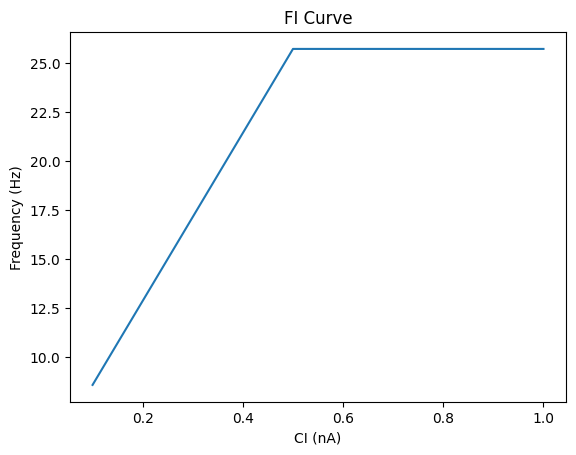

In [9]:
plt.plot([0.1, 0.5, 1.0], frequencies)
plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")

2. Assume passive properties are optimized offline (see the notebook on PP tuning). Optimize active channels.

In [10]:
random_state = np.random.RandomState(123)

In [11]:
# Parameter ranges as if provided by the user
gbar_na = 0.12
gbar_kdr = 0.036

gbar_na_range = (gbar_na - random_state.uniform(0, gbar_na / 2), gbar_na + random_state.uniform(0, gbar_na / 2))
gbar_kdr_range = (gbar_kdr - random_state.uniform(0, gbar_kdr / 2), gbar_kdr + random_state.uniform(0, gbar_kdr / 2))

print(f"Na: {gbar_na_range}")
print(f"Kdr: {gbar_kdr_range}")

Na: (0.0782118488641283, 0.13716836009702277)
Kdr: (0.031916673835844345, 0.04592366584349204)


In [12]:
# Define the train cell
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "/home/ubuntu/ACT/data/Spiker/orig/template.hoc",
    path_to_mod_files = "/home/ubuntu/ACT/data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [13]:
sim_params = SimulationParameters(
    sim_name = "spiker_orig_train",
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100, lto_hto = 0),
          ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0),
          ConstantCurrentInjection(amp = 1.0, dur = 700, delay = 100, lto_hto = 0)])

optim_params = OptimizationParameters(
    conductance_options = [
        ConductanceOptions(variable_name = "hh_spiker.gnabar", low = gbar_na_range[0], high = gbar_na_range[1], n_slices = 3),
        ConductanceOptions(variable_name = "hh_spiker.gkbar", low = gbar_kdr_range[0], high = gbar_kdr_range[1], n_slices = 3),  
    ],
    train_features = 
    ["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "number_of_troughs", "trough_times", "trough_height_stats"],
    prediction_eval_method = 'fi_curve',
    spike_threshold = 0,
    filter_parameters = FilterParameters(
        saturation_threshold = -55,
        window_of_inspection = (100, 800)
    ),
    first_n_spikes = 20,
    random_state = 123,
    save_file = f"output/spiker_orig/results/saved_metrics.json"
)

original_module = ACTModule(
    ACTModuleParameters(
        module_folder_name = "output/spiker_orig",
        cell = train_cell,
        target_traces_file = f"output/spiker_orig/target/combined_out.npy",
        sim_params = sim_params,
        optim_params = optim_params
    )
)

In [14]:
predicted_g_data_file = original_module.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
conductance combo 0: [0.0782118488641283, 0.031916673835844345]
conductance combo 1: [0.0782118488641283, 0.031916673835844345]
conductance combo 2: [0.0782118488641283, 0.031916673835844345]
conductance combo 3: [0.0782118488641283, 0.038920169839668194]
conductance combo 4: [0.0782118488641283, 0.038920169839668194]
conductance combo 5: [0.0782118488641283, 0.038920169839668194]
conductance combo 6: [0.0782118488641283, 0.04592366584349204]
conductance combo 7: [0.0782118488641283, 0.04592366584349204]
conductance combo 8: [0.0782118488641283, 0.04592366584349204]
conductance combo 9: [0.10769010448057553, 0.031916673835844345]
conductance combo 10: [0.10769010448057553, 0.031916673835844345]
conductance combo 11: [0.10769010448057553, 0.031916673835844345]
conductance combo 12: [0.10

In [16]:
pickle_rf(original_module.rf_model,f"output/spiker_orig/results/trained_rf.pkl")

# Results and Metrics

In [17]:
final_folder = "output/spiker_orig"

from act.act_plot import *
plot_v_comparison(
    final_folder,
    predicted_g_data_file, 
    sim_params.CI,
    sim_params.h_dt
    )

plot_fi_comparison(
    final_folder, 
    sim_params.CI
    )

In [18]:
from act.metrics import *

mean, stdev = save_interspike_interval_comparison(
    final_folder,
    predicted_g_data_file,
    sim_params.CI, 
    sim_params.h_dt,
    first_n_spikes=5,
    save_file=f"{final_folder}/results/saved_metrics.json"
)

'''
"gnabar_hh_orig" = 0.12
"gkbar_hh_orig"=0.036
"gl_hh_orig"=0.0003
'''

actual_g={"gnabar_hh_spiker": 0.12,"gkbar_hh_spiker": 0.036}

    
save_prediction_g_mae(
    actual_g=actual_g,
    save_file=f"{final_folder}/results/saved_metrics.json"
)

save_feature_mae(
    final_folder,
    predicted_g_data_file,
    ["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "trough_times", "trough_height_stats", "lto-hto_amplitude", "lto-hto_frequency"],
    sim_params.h_dt,
    first_n_spikes=5,
    CI_settings=sim_params.CI,
    save_file=f"{final_folder}/results/saved_metrics.json"
)

clear_directory(final_folder + "/train/")


Interspike times (Target): [[1.54e+01 1.52e+01 1.51e+01 1.51e+01]
 [9.90e+00 9.10e+00 9.00e+00 9.00e+00]
 [1.00e+06 1.00e+06 1.00e+06 1.00e+06]]
Interspike times (Prediction): [[1.56e+01 1.53e+01 1.54e+01 1.53e+01]
 [9.90e+00 9.10e+00 9.10e+00 9.00e+00]
 [1.00e+06 1.00e+06 1.00e+06 1.00e+06]]
MAE for each I injection: [0.19999999999999574, 0.025000000000005684, 0.0]
Mean interspike-interval MAE: 0.07500000000000047
Standard Deviation interspike-interval MAE: 0.08897565210025787
MAE of final g prediction: 0.005365400857545298
MAE of summary features for final prediction: 0.12790354376173457
Deleting Train Data: output/spiker_orig/train/
